# Heart Attack - Kaggle competition  V 3.0

Author: _Aniko Maraz, PhD_

<div class="alert alert-block alert-info">
    
This is an <a href="https://www.kaggle.com/competitions/heart-attack-risk-analysis/overview">active Kaggle competition</a>  for Kudos. <br>    
The task is to predict (on an unseen dataset) if the patient is at low or high risk of heart attack.  <br>

This notebook is my 3rd attempt to optimise the model for accuracy. I hypertuned the SVC model and the Neural Network, because both had similar accuracy. However, when submitting to the competition, the accuracy remained the same as for the un-tuned models (and the same for SVC and Neural Network models). The 1st attempt got me to place 56, the second (and now the third attempt) to 46, although places 9-46 have the exact same accuracy in the competition. <br>

</div>

## Imports

In [16]:
import numpy as np
import pandas as pd
from dataprep.eda import create_report

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
)

from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# tensorflow ==2.12.0
# keras==2.12.0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance

import jupyter_black
import warnings

%load_ext jupyter_black
%matplotlib inline

# Display all columns in the DataFrame throughout the Notebook
pd.set_option("display.max_columns", None)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## DATA: GET AND EXPLORE

In [18]:
df_raw_train = pd.read_csv("data/train.csv")
df_raw_train.shape

(7010, 26)

In [19]:
df_raw_train.head()

Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    RDG0550   33    Male          200         129/90          48         0   
1    NMA3851   56  Female          262        159/105          46         1   
2    TUI5807   19  Female          140        161/109          54         0   
3    YYT5016   50  Female          163         120/62          53         0   
4    ZAC5937   89  Female          144        153/110          92         1   

   Family History  Smoking  Obesity  Alcohol Consumption  \
0               1        1        1                    1   
1               0        1        0                    0   
2               1        0        0                    1   
3               1        1        1                    1   
4               0        1        0                    1   

   Exercise Hours Per Week       Diet  Previous Heart Problems  \
0                 7.807690  Unhealthy                        0   
1                17.297628    Average                        1   
2                 8.695288    Average                        1   
3                10.161587    Healthy                        0   
4                16.436787    Healthy                        1   

   Medication Use  Stress Level  Sedentary Hours Per Day  Income        BMI  \
0               1             2                 0.138443  184066  30.449815   
1               0             8                 0.369552  211755  34.973685   
2               1             3                 8.646334  252203  30.554246   
3               1             7                 1.107884  121954  35.390265   
4               0             1                 1.337570  180121  39.575483   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0             63                                6                    7   
1            333                                7                    8   
2            537                                2                   10   
3            591                                0                    9   
4            145                                2                    5   

     Country      Continent           Hemisphere  Heart Attack Risk  
0  Argentina  South America  Southern Hemisphere                  1  
1    Nigeria         Africa  Northern Hemisphere                  1  
2   Thailand           Asia  Northern Hemisphere                  0  
3      Spain         Europe  Southern Hemisphere                  1  
4    Germany         Europe  Northern Hemisphere                  1

In [4]:
report = create_report(df_raw_train)
# report.save('report_heart_attack')

  0%|                                                  | 0/3307 [00:00<?, ?it/s]

/home/aniko/.local/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/aniko/.local/lib/python3.10/site-packages/dataprep/eda/distribution/render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
/home/aniko/.local/lib/python3.10/site-packages/dataprep/eda/distribution/render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
/home/aniko/.local/lib/python3.10/site-packages/dataprep/eda/distribution/render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = d

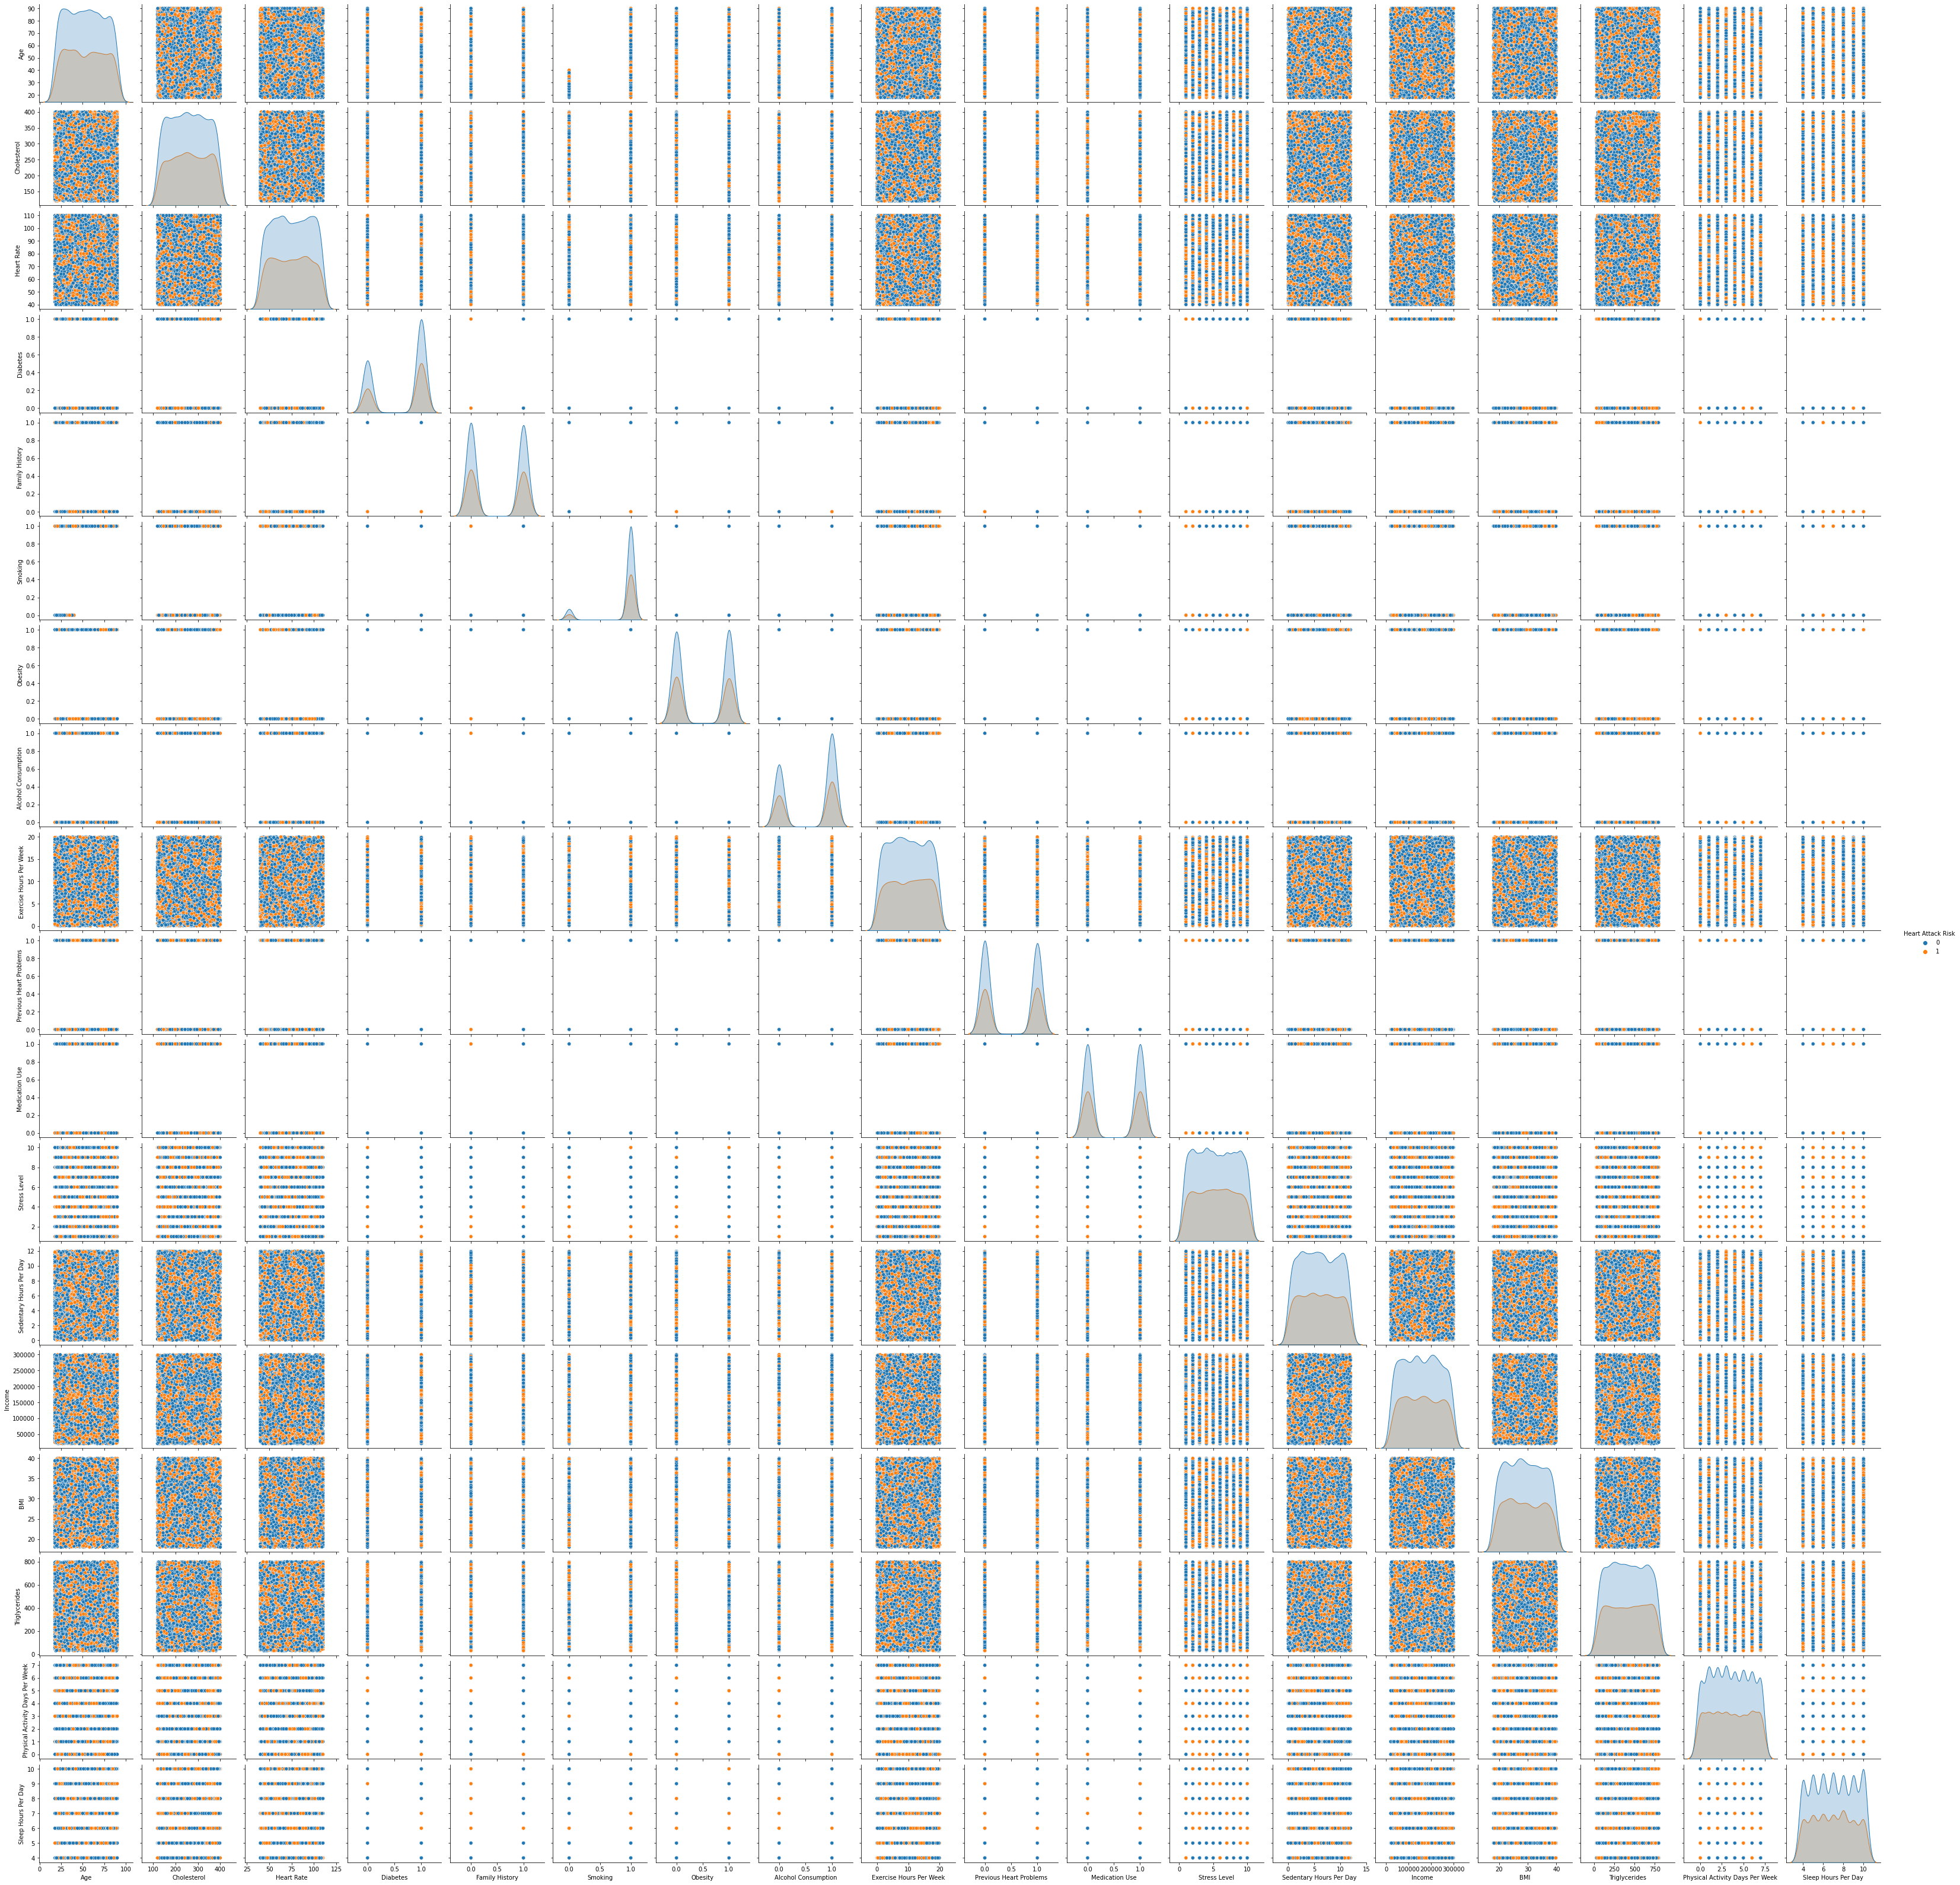

In [15]:
sns.pairplot(df_raw_train, hue="Heart Attack Risk")

The [statistical description of features](https://github.com/anikomaraz/heart_attack_kaggle/blob/main/report_heart_attack.html) is available in V 1.0 of the notebook. Features' data contain no missing values or outliers, most features are close to normal distribution, classes contain approximately the same data points. There are 7010 rows (patients) and 25 features. 

## PREPROCESSING PIPELINE

In [20]:
# def function to split blood pressure data (current format: 129/90)
def split_blood_pressure(df):
    df[["Systolic", "Diastolic"]] = df["Blood Pressure"].str.split("/", expand=True)
    df["Systolic"] = pd.to_numeric(df["Systolic"])
    df["Diastolic"] = pd.to_numeric(df["Diastolic"])
    df.drop(columns=["Blood Pressure"], inplace=True)


# split cholesterol according to sample mean
cholesterol_sample_mean = df_raw_train["Cholesterol"].mean()


def split_cholesterol_sample(df):
    df["Cholesterol_sample_split"] = np.where(
        df["Cholesterol"] > cholesterol_sample_mean, 1, 0
    )


# total excercise
def exercise_total(df):
    df["Exercise Total"] = (
        df["Exercise Hours Per Week"] * df["Physical Activity Days Per Week"]
    )


# construct the ratio of systolic and diastolic blood pressure
def systolic_diastolic_ratio_constructor(df):
    df["Systolic_Diastolic_Ratio"] = df["Systolic"] / df["Diastolic"]


# create the new variables
df = df_raw_train.copy()

split_blood_pressure(df=df)
split_cholesterol_sample(df=df)
exercise_total(df=df)
systolic_diastolic_ratio_constructor(df=df)

### Define features

In [21]:
# Defining the features and the target
X = df.drop(columns="Heart Attack Risk")
y = df["Heart Attack Risk"]

In [22]:
# Opt-in continuous and categorical variables
continuous_vars = [
    "Age",
    # "Cholesterol",
    "Heart Rate",
    "Exercise Hours Per Week",
    "Stress Level",
    "Sedentary Hours Per Day",
    "Income",
    "BMI",
    "Triglycerides",
    "Physical Activity Days Per Week",
    "Sleep Hours Per Day",
    "Systolic",
    "Diastolic",
    # "Exercise Total",
    # "Systolic_Diastolic_Ratio",
]

categorical_vars = [
    "Diabetes",
    "Family History",
    "Obesity",
    "Alcohol Consumption",
    "Previous Heart Problems",
    "Medication Use",
    "Cholesterol_sample_split",
    # "Smoking",
    "Sex",
    "Continent",
    "Diet",
    "Hemisphere",
    # "Country",
]

X_selected = X[continuous_vars + categorical_vars]

### Create preprocessing pipeline and train/test data

In [23]:
# Define preprocessing steps for continuous and categorical features
num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(drop="first")

preproc_basic = ColumnTransformer(
    transformers=[
        ("num", num_transformer, continuous_vars),
        ("cat", cat_transformer, categorical_vars),
    ],
    remainder="passthrough",
)


def create_nn_model():
    model = Sequential()
    model.add(Dense(16, input_dim=28, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))  # Output layer
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


# Create pipelines for each classifier
logistic_regression_pipe = make_pipeline(
    preproc_basic, LogisticRegression(random_state=6)
)
svm_pipe = make_pipeline(preproc_basic, SVC(random_state=6))
xgboost_pipe = make_pipeline(preproc_basic, XGBClassifier(random_state=6))
decision_tree_pipe = make_pipeline(
    preproc_basic, DecisionTreeClassifier(random_state=6)
)
random_forest_pipe = make_pipeline(
    preproc_basic, RandomForestClassifier(random_state=6)
)
gradient_boosting_pipe = make_pipeline(
    preproc_basic, GradientBoostingClassifier(random_state=6)
)
nn_pipe = make_pipeline(
    preproc_basic,
    KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=0),
)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=6
)

/tmp/ipykernel_25090/3016406969.py:39: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=0),


In [9]:
preproc_basic

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 ['Age', 'Heart Rate',
                                  'Exercise Hours Per Week', 'Stress Level',
                                  'Sedentary Hours Per Day', 'Income', 'BMI',
                                  'Triglycerides',
                                  'Physical Activity Days Per Week',
                                  'Sleep Hours Per Day', 'Systolic',
                                  'Diastolic']),
                                ('cat', OneHotEncoder(drop='first'),
                                 ['Diabetes', 'Family History', 'Obesity',
                                  'Alcohol Consumption',
                                  'Previous Heart Problems', 'Medication Use',
                                  'Cholesterol_sample_split', 'Sex',
                                  'Continent', 'Diet', 'Hemisphere'])])

## FIT and EVALUATE pipeline with competing classification models

In [24]:
pipes = [
    logistic_regression_pipe,
    svm_pipe,
    xgboost_pipe,
    decision_tree_pipe,
    random_forest_pipe,
    gradient_boosting_pipe,
    nn_pipe,
]

for pipe in pipes:
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)

# Cross-validate each pipeline
for pipe, name in [
    (logistic_regression_pipe, "Logistic Regression"),
    (svm_pipe, "SVM"),
    (xgboost_pipe, "XGBoost"),
    (decision_tree_pipe, "Decision Tree"),
    (random_forest_pipe, "Random Forest"),
    (gradient_boosting_pipe, "Gradient Boosting"),
    (nn_pipe, "Neural Network"),
]:
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()
    print(f"Cross-validated accuracy for {name}: {cv_score}")

Cross-validated accuracy for Logistic Regression: 0.6425514510942116
Cross-validated accuracy for SVM: 0.6427553246925807
Cross-validated accuracy for XGBoost: 0.5952729144997312
Cross-validated accuracy for Decision Tree: 0.5469685739851476
Cross-validated accuracy for Random Forest: 0.6341959553305058
Cross-validated accuracy for Gradient Boosting: 0.6331759645068937
31/31 [==============================] - 0s 1ms/step
Cross-validated accuracy for Neural Network: 0.6407174191512464


Based on the above accuracies, I picked the SVM for fine-tuning.

In [26]:
# Fit preprocessing on the entire dataset
X_train_preprocessed = preproc_basic.fit_transform(X_train)

# Convert the transformed data to a DataFrame
X_train_preprocessed_df = pd.DataFrame(
    X_train_preprocessed,
    columns=continuous_vars
    + list(
        preproc_basic.named_transformers_["cat"].get_feature_names_out(categorical_vars)
    ),
)

#### Check multicollinearity

In [27]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_preprocessed_df.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_train_preprocessed_df.values, i)
    for i in range(X_train_preprocessed_df.shape[1])
]

In [ ]:
vif_data

### Check features' distribution

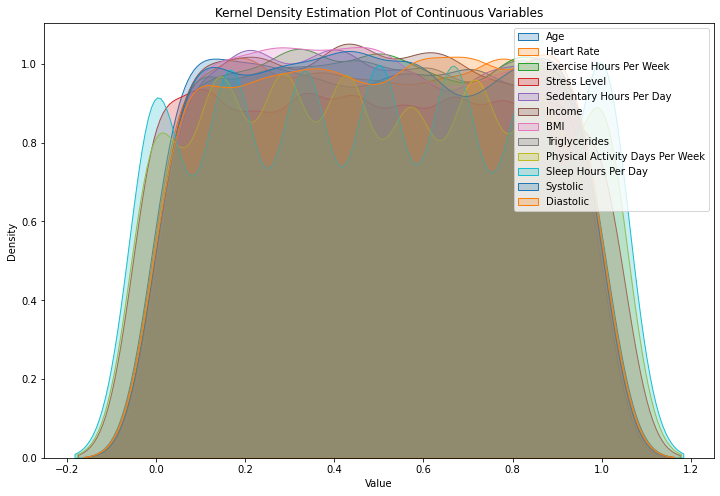

In [29]:
# Select only the continuous variables
number_of_features = len(continuous_vars)
continuous_data = X_train_preprocessed_df.iloc[:, :number_of_features]
continuous_df = pd.DataFrame(continuous_data, columns=continuous_vars)

# Plot KDE for each continuous variable
plt.figure(figsize=(12, 8))
for column in continuous_df.columns:
    sns.kdeplot(continuous_df[column], label=column, fill=True)

plt.title("Kernel Density Estimation Plot of Continuous Variables")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Because of the one-hot-encoding all categorical features now take 2 values (0 or 1), so I will stack them accordingly.

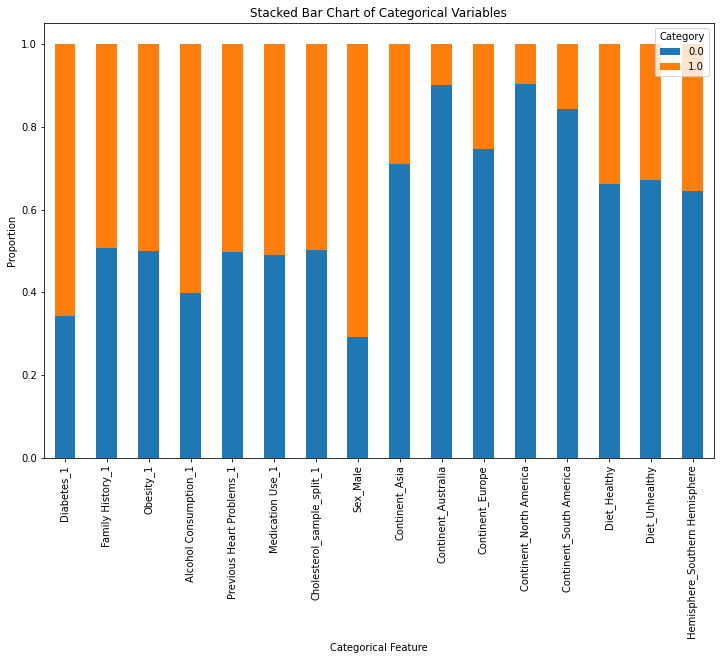

In [30]:
# Select categorical features
continuous_feature_count = len(continuous_vars)
categorical_data = X_train_preprocessed_df.iloc[:, continuous_feature_count:]

categorical_df = pd.DataFrame(categorical_data)

# Aggregate counts for the plot
proportions_df = categorical_df.apply(lambda x: x.value_counts(normalize=True)).T

# Plot stacked bar chart
proportions_df.plot(kind="bar", stacked=True, figsize=(12, 8))

plt.title("Stacked Bar Chart of Categorical Variables")
plt.xlabel("Categorical Feature")
plt.ylabel("Proportion")
plt.legend(title="Category")
plt.show()

### Fine tuning the NN

In [31]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


# Define the Keras model as a function
def create_nn_model(optimizer="adam", activation="relu"):
    model = Sequential()
    model.add(Dense(128, input_dim=28, activation=activation))
    model.add(Dense(64, activation=activation))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


# Create KerasClassifier
model = KerasClassifier(build_fn=create_nn_model, verbose=0)

# Define parameters for grid search
param_grid = {
    "batch_size": [16, 32, 64],
    "epochs": [10, 20, 30],
    "optimizer": ["adam", "sgd"],
    "activation": ["relu", "tanh"],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring="accuracy")
grid_result = grid.fit(X_train_preprocessed, y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/tmp/ipykernel_25090/702952195.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_nn_model, verbose=0)


52/52 [==============================] - 0s 1ms/step
Best: 0.642959 using {'activation': 'tanh', 'batch_size': 64, 'epochs': 30, 'optimizer': 'sgd'}


### Fine tuning the SVM model

In [16]:
svm_pipe = Pipeline([("preprocessing", preproc_basic), ("svm", SVC())])

# Parameter grid for GridSearchCV
param_grid = {
    "svm__C": [0.0001, 0.001, 0.01, 0.05, 0.1],
    "svm__class_weight": [None, "balanced"],
}


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svm_pipe, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=8
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

# Evaluate on test set
test_accuracy = grid_search.score(X_test, y_test)
print("Test Set Accuracy:", test_accuracy)

Best Parameters: {'svm__C': 0.0001, 'svm__class_weight': None}
Best Cross-Validated Accuracy: 0.6427553246925807
Test Set Accuracy: 0.6428911079410367


## PREDICT

In [34]:
df_kaggle_test = pd.read_csv("data/test.csv")  # read in test data provided by Kaggle

In [35]:
# preprocess Kaggle data
df_kaggle_test = df_kaggle_test.copy()

split_blood_pressure(df=df_kaggle_test)
split_cholesterol_sample(df=df_kaggle_test)
exercise_total(df=df_kaggle_test)
systolic_diastolic_ratio_constructor(df=df_kaggle_test)

X_df_kaggle_test_selected = df_kaggle_test[continuous_vars + categorical_vars]

In [57]:
# Create SVM pipeline with best parameters
best_params = {"C": 0.0001, "kernel": "linear", "gamma": "scale", "class_weight": None}

svm_pipe = Pipeline(
    [
        ("preprocessor", preproc_basic),
        ("classifier", SVC(**best_params, random_state=6)),
    ]
)

# Train the SVM model on the entire preprocessed training dataset
svm_pipe.fit(X_selected, y)

# Make predictions on the df_kaggle_test data
kaggle_test_predictions_v3_svc = svm_pipe.predict(X_df_kaggle_test_selected)
kaggle_test_predictions_v3_svc

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
# Create KerasClassifier with best parameters

best_params = {"activation": "tanh", "batch_size": 64, "epochs": 30, "optimizer": "sgd"}
model = KerasClassifier(build_fn=create_nn_model, **best_params, verbose=0)

# Create pipeline for NN
nn_pipe = Pipeline([("preprocessor", preproc_basic), ("classifier", model)])

# Fit the pipeline on the preprocessed training dataset
nn_pipe.fit(X_train, y_train)

# Make predictions on the X_df_kaggle_test_selected data
kaggle_test_predictions_v3_nn = nn_pipe.predict(X_df_kaggle_test_selected)
kaggle_test_predictions_v3_nn = kaggle_test_predictions.ravel()

# Print predictions
kaggle_test_predictions_v3_nn

/tmp/ipykernel_25090/873291135.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_nn_model, **best_params, verbose=0)


55/55 [==============================] - 0s 1ms/step


array([0, 0, 0, ..., 0, 0, 0])

### Prepare submission

In [58]:
df_kaggle_predicted_V3 = {
    "Patient ID": df_kaggle_test["Patient ID"],
    "Heart Attack Risk": kaggle_test_predictions_v3_svc,
}
# predict_df = pd.DataFrame(df_kaggle_preprocessed.index, kaggle_test_predictions)
df_kaggle_predicted_V3 = pd.DataFrame(df_kaggle_predicted_V3)
df_kaggle_predicted_V3

Patient ID  Heart Attack Risk
0       BMW7812                  0
1       XXM0972                  0
2       RQX1211                  0
3       RVN4963                  0
4       NCU1956                  0
...         ...                ...
1748    GQZ5013                  0
1749    FDK8693                  0
1750    SVO4635                  0
1751    KQR8949                  0
1752    XKA5925                  0

[1753 rows x 2 columns]

In [59]:
df_kaggle_predicted_V3.to_csv("submission/df_kaggle_predicted_V3.csv", index=False)

## Evaluation on Kaggle